In [1]:
import os
import numpy as np
from PIL import Image
import zipfile
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from sklearn import svm
from tensorflow.keras import layers, models
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from transformers import GPT2Tokenizer, GPT2LMHeadModel, Trainer, TrainingArguments
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, Dense, LayerNormalization, Dropout, Input
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
import contractions
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.losses import MeanSquaredError

In [2]:
# Function to load and inspect images and labels from subdirectories
def classimages(folder, num_images=5):
    images, labels = [], []
    for subdir in os.listdir(folder):
        subdir_path = os.path.join(folder, subdir)
        if os.path.isdir(subdir_path):
            for i, filename in enumerate(os.listdir(subdir_path)):
                if i >= num_images:
                    break
                if filename.endswith(('.jpg', '.png')):
                    img = Image.open(os.path.join(subdir_path, filename))
                    img = img.resize((128, 128))
                    img = img.convert('L')
                    images.append(np.array(img))
                    labels.append(subdir)  
    return images, labels

In [3]:
df = 'C:/Users/nabil/Downloads/sentiment_data'
train_df = os.path.join(df, 'train')
test_df = os.path.join(df, 'test')

In [4]:
# Inspect a few images and labels from the train and test folders
trainimages, train_labels_sample = classimages(train_df)
testimages, test_labels_sample = classimages(test_df)

In [5]:
# Preprocess the data
def preprocess(images):
    images = np.array(images)
    images = images.astype('float32') / 255.0  # Normalize to [0, 1]
    images = np.expand_dims(images, axis=-1)  # Add channel dimension
    return images

train_images = preprocess(trainimages)
test_images = preprocess(testimages)

In [6]:
# Define the encoder model
input_shape = (128, 128, 1)
latent_dim = 64

encoder_inputs = layers.Input(shape=input_shape)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoder_inputs)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Flatten()(x)
x = layers.Dense(latent_dim, activation='relu')(x)

encoder = models.Model(encoder_inputs, x, name='encoder')

In [7]:
# Define the decoder model
latent_inputs = layers.Input(shape=(latent_dim,))
x = layers.Dense(16 * 16 * 128, activation='relu')(latent_inputs)
x = layers.Reshape((16, 16, 128))(x)
x = layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoder_outputs = layers.Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')(x)

decoder = models.Model(latent_inputs, decoder_outputs, name='decoder')

In [8]:
# Define the VAE model
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        return reconstructed

In [9]:
# Instantiate and compile the VAE model with a lower learning rate
vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mean_squared_error')

In [10]:
image_size = (64, 64)
batch_size = 32

# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [11]:
# Load the train, validation, and test datasets
train_generator = train_datagen.flow_from_directory(train_df,target_size=image_size,batch_size=batch_size,class_mode='input',color_mode='grayscale',subset='training')

validation_generator = train_datagen.flow_from_directory(train_df,target_size=image_size,batch_size=batch_size,class_mode='input',color_mode='grayscale',subset='validation')

test_generator = test_datagen.flow_from_directory(test_df,target_size=image_size,batch_size=batch_size,class_mode='input',color_mode='grayscale')

Found 22619 images belonging to 6 classes.
Found 5654 images belonging to 6 classes.
Found 7067 images belonging to 6 classes.


In [12]:
# Load the train, validation, and test datasets
train_generator = train_datagen.flow_from_directory(train_df,target_size=(128, 128),batch_size=32,class_mode='input',color_mode='grayscale',subset='training')

validation_generator = train_datagen.flow_from_directory(train_df,target_size=(128, 128),batch_size=32,class_mode='input',color_mode='grayscale',subset='validation')

test_generator = test_datagen.flow_from_directory(test_df,target_size=(128, 128),batch_size=32,class_mode='input',color_mode='grayscale')


Found 22619 images belonging to 6 classes.
Found 5654 images belonging to 6 classes.
Found 7067 images belonging to 6 classes.


In [13]:
def build_autoencoder(input_shape):
    input_img = layers.Input(shape=input_shape)

    # Encoder
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    vae_autoencoder = models.Model(input_img, decoded)
    return vae_autoencoder

In [14]:
input_shape = (128, 128, 1)
vae_autoencoder = build_autoencoder(input_shape)
vae_autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mean_squared_error')

In [15]:
# Train the model
vae_autoencoder.fit(train_generator,epochs=20,validation_data=validation_generator)

Epoch 1/20


C:\Users\nabil\anaconda3\New folder\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


707/707 ━━━━━━━━━━━━━━━━━━━━ 698s 977ms/step - loss: 0.0195 - val_loss: 0.0027
Epoch 2/20
707/707 ━━━━━━━━━━━━━━━━━━━━ 495s 699ms/step - loss: 0.0026 - val_loss: 0.0021
Epoch 3/20
707/707 ━━━━━━━━━━━━━━━━━━━━ 561s 792ms/step - loss: 0.0021 - val_loss: 0.0018
Epoch 4/20
707/707 ━━━━━━━━━━━━━━━━━━━━ 439s 619ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 5/20
707/707 ━━━━━━━━━━━━━━━━━━━━ 439s 621ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 6/20
707/707 ━━━━━━━━━━━━━━━━━━━━ 405s 573ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 7/20
707/707 ━━━━━━━━━━━━━━━━━━━━ 404s 570ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 8/20
707/707 ━━━━━━━━━━━━━━━━━━━━ 406s 574ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 9/20
707/707 ━━━━━━━━━━━━━━━━━━━━ 405s 572ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 10/20
707/707 ━━━━━━━━━━━━━━━━━━━━ 408s 576ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 11/20
707/707 ━━━━━━━━━━━━━━━━━━━━ 404s 570ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 12/20
707/707

In [16]:
# Function to display images
def printimages(original, reconstructed, n=10):
    plt.figure(figsize=(15, 5))
    for i in range(n):
        # Display original images
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original[i].reshape(128, 128), cmap='gray')
        plt.title("Input image")
        plt.axis("off")
        
        # Display generated images
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructed[i].reshape(128, 128), cmap='gray')
        plt.axis("off")
        plt.title("Generated image")
        plt.axis("off")
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step


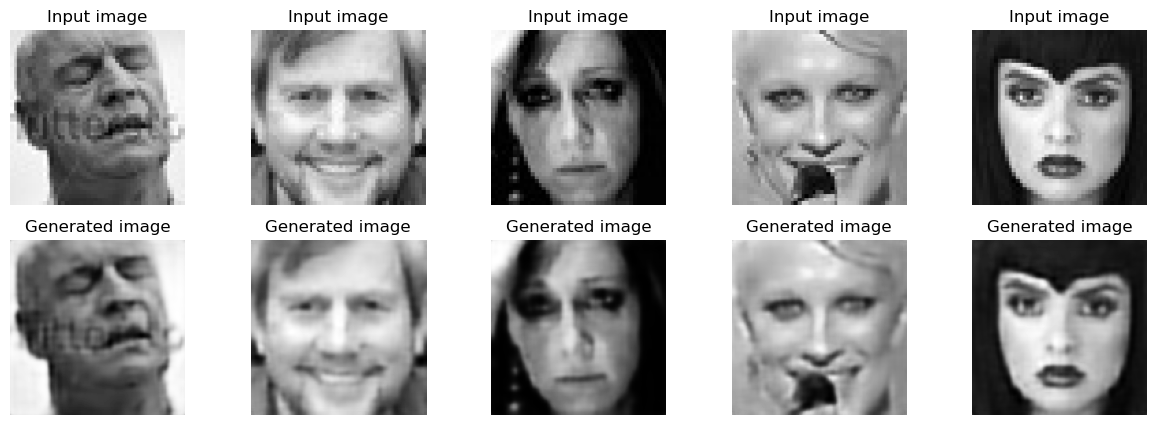

In [17]:
num = 5
testimages, _ = next(test_generator)
reconstructed_images = vae_autoencoder.predict(testimages[:num])

printimages(testimages, reconstructed_images, num)

In [20]:
!pip install flask

In [23]:
from flask import Flask, send_file
import pickle

with open('vae_autoencoder.pkl', 'wb') as f:
    pickle.dump(vae_autoencoder, f)

app = Flask(__name__)

@app.route('/download_model', methods=['GET'])
def download_model():
    return send_file('vae_autoencoder.pkl', as_attachment=True, download_name='vae_autoencoder.pkl')

if __name__ == '__main__':
    app.run(debug=False)

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit


In [25]:
vae_autoencoder.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 128, 128, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 128, 128, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_3 (UpSampling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 32, 32, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_4 (UpSampling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 64, 64, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_5 (UpSampling2D)       │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 128, 128, 1)         │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 998,405 (3.81 MB)

 Trainable params: 332,801 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 665,604 (2.54 MB)